### Youmin Ko

### CO2 Emission Dataset from Kaggle

**Summary**: This data has been gathered at two solar power plants in *India* over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.

**Original Source**: This dataset is come from India goverment, National Data Sharing and Accessibility Policy (NDSAP) API. 

- Every solar power plant consists at least of two basic components:  
    1. Modules- that convert sunlight into electricity  
    2. One or more inverters- devices that convert direct current into alternating current.

### Columns & Definition
- DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
- PLANT_ID: Plant ID - this will be common for the entire file.
- SOURCE_KEY: Source key in this file stands for the inverter id.
- DC_POWER: Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
- AC_POWER: Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
- DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time.
- TOTAL_YIELD: This is the total yield for the inverter till that point in time.

<p align="center">
<img width="800" alt="1" src="https://user-images.githubusercontent.com/111734605/231407024-3c724d14-39f5-475c-a6f0-b23e662af667.png">
</p>

In [1]:
# Installing Packages
## !pip install numpy
## !pip install pandas
## !pip install matplotlib
## !pip install seaborn
## !pip install plotly

In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)


import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [24]:
# Import all available data 
df_gen1 = pd.read_csv("https://raw.githubusercontent.com/meaningful96/DSKUS_Project/main/Dataset/Solar_Energy/Plant_1_Generation_Data.csv")
df_gen2 = pd.read_csv("https://raw.githubusercontent.com/meaningful96/DSKUS_Project/main/Dataset/Solar_Energy/Plant_2_Generation_Data.csv")

df_weather1 = pd.read_csv("https://raw.githubusercontent.com/meaningful96/DSKUS_Project/main/Dataset/Solar_Energy/Plant_1_Weather_Sensor_Data.csv")
df_weather2 = pd.read_csv("https://raw.githubusercontent.com/meaningful96/DSKUS_Project/main/Dataset/Solar_Energy/Plant_2_Weather_Sensor_Data.csv")

### Check for issues

In [26]:
df_gen1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [28]:
df_weather1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB



- DATE_TIME and PLANT_ID are identical with the description above. Other than that:
    - SOURCE_KEY: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.
    - AMBIENT_TEMPERATURE: This is the ambient temperature at the plant. Note: After comparing this data with weather data in Gandikotta (Andhra), I assume the correct unit for this data is  °C
    - MODULE_TEMPERATURE: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. Note: After comparing this data with other publications, I assume the correct unit for this data is  °C
    - IRRADATION: Amount of irradiation for the 15 minute interval. Note: After comparing this data with other publications, I assume the correct unit for this data is  kW/m2

In [33]:
# quick stat overview of datasets
df_gen1.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


In [32]:
df_weather1.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182.0,3182.000000,3182.000000,3182.000000
mean,4135001.0,25.531606,31.091015,0.228313
std,0.0,3.354856,12.261222,0.300836
min,4135001.0,20.398505,18.140415,0.000000
25%,4135001.0,22.705182,21.090553,0.000000
50%,4135001.0,24.613814,24.618060,0.024653
75%,4135001.0,27.920532,41.307840,0.449588
max,4135001.0,35.252486,65.545714,1.221652


In [34]:
# Check missing values
df_gen1.isnull().sum().sort_values(ascending=False)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

In [35]:
# Check missing values
df_gen1.isnull().sum().sort_values(ascending=False)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

It looks like we have no missing values. We can use the PLANT_ID column to check if our data only contains information of one power plant:

In [36]:
df_gen1['PLANT_ID'].nunique()
df_weather1['PLANT_ID'].nunique()

1

In [37]:
df_gen1.SOURCE_KEY.value_counts()

bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64

In [38]:
df_gen1.SOURCE_KEY.value_counts().sum()

68778

In [39]:
print('There are {} different inverters. Number of measurements per inverter range from {} to {}.' .format(df_gen1.SOURCE_KEY.nunique(),df_gen1.SOURCE_KEY.value_counts().min(), df_gen1.SOURCE_KEY.value_counts().max() ))

There are 22 different inverters. Number of measurements per inverter range from 3104 to 3155.


As we can see there are 22 different inverters with between 3104 and 3155 measurements. This difference may cause an issue with prediction models and should be taken into account. Since one entry corresponds to a 15 min measurement, the maximum difference of 51 entries corresponds to a difference of almost 13 hours.

### Preprocess and merge datasets
We want to merge both datasets. To do this we adjust the DATE_TIME formats, drop unnecessary columns and merge along DATE_TIME. In addition, we are going to add separate date and time columns as well as name our inverters from 1 to 22.

In [40]:
# adjust datetime format
df_gen1['DATE_TIME'] = pd.to_datetime(df_gen1['DATE_TIME'],format = '%d-%m-%Y %H:%M')
df_weather1['DATE_TIME'] = pd.to_datetime(df_weather1['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')

# drop unnecessary columns and merge both dataframes along DATE_TIME
df_plant1 = pd.merge(df_gen1.drop(columns = ['PLANT_ID']), df_weather1.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

In [41]:
# add inverter number column to dataframe
sensorkeys = df_plant1.SOURCE_KEY.unique().tolist() # unique sensor keys
sensornumbers = list(range(1,len(sensorkeys)+1)) # sensor number
dict_sensor = dict(zip(sensorkeys, sensornumbers)) # dictionary of sensor numbers and corresponding keys

# add column
df_plant1['SENSOR_NUM'] = 0
for i in range(df_gen1.shape[0]):
    df_plant1['SENSOR_NUM'][i] = dict_sensor[df_gen1["SOURCE_KEY"][i]]

# add Sensor Number as string
df_plant1["SENSOR_NAME"] = df_plant1["SENSOR_NUM"].apply(str) # add string column of sensor name

In [45]:
# adding separate time and date columns
df_plant1["DATE"] = pd.to_datetime(df_plant1["DATE_TIME"]).dt.date # add new column with date
df_plant1["TIME"] = pd.to_datetime(df_plant1["DATE_TIME"]).dt.time # add new column with time

# add hours and minutes for ml models
df_plant1['HOURS'] = pd.to_datetime(df_plant1['TIME'],format='%H:%M:%S').dt.hour
df_plant1['MINUTES'] = pd.to_datetime(df_plant1['TIME'],format='%H:%M:%S').dt.minute
df_plant1['MINUTES_PASS'] = df_plant1['MINUTES'] + df_plant1['HOURS']*60

# add date as string column
df_plant1["DATE_STR"] = df_plant1["DATE"].astype(str) # add column with date as string

In [ ]:
df_plant1.head()

### Data Exploration & Failure Detection


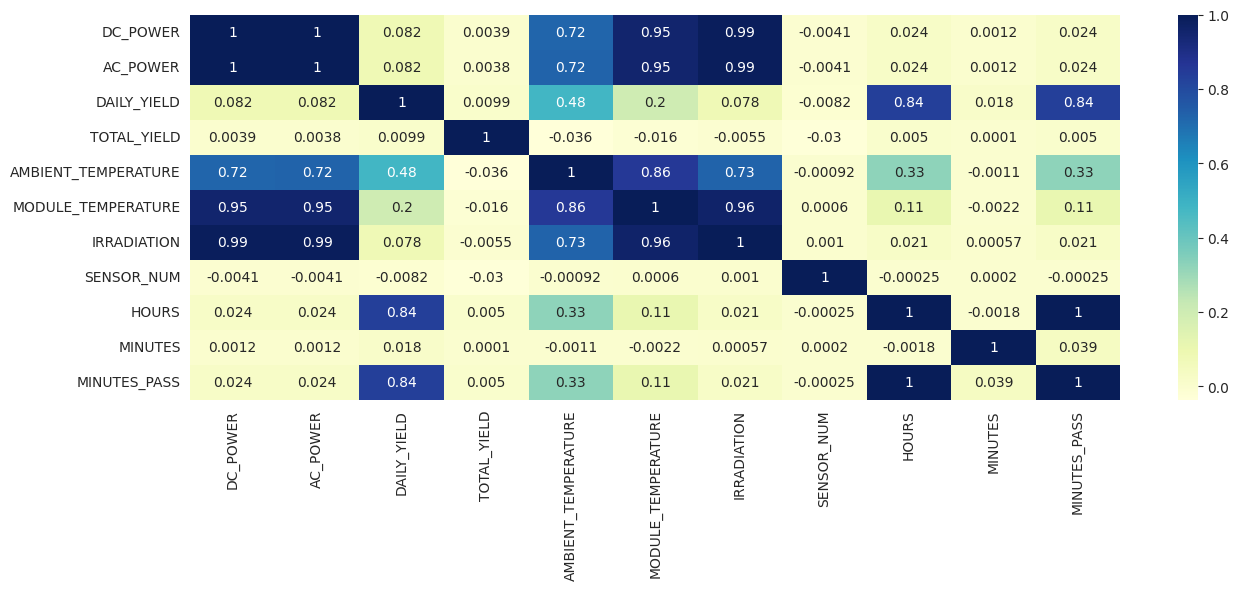

In [46]:
cols_corr = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "SENSOR_NUM", "HOURS", "MINUTES", "MINUTES_PASS"]
corrMatrix = df_plant1[cols_corr].corr()
plt.figure(figsize=(15,5))
fig_corr = sns.heatmap(corrMatrix,cmap="YlGnBu", annot=True)
plt.show()

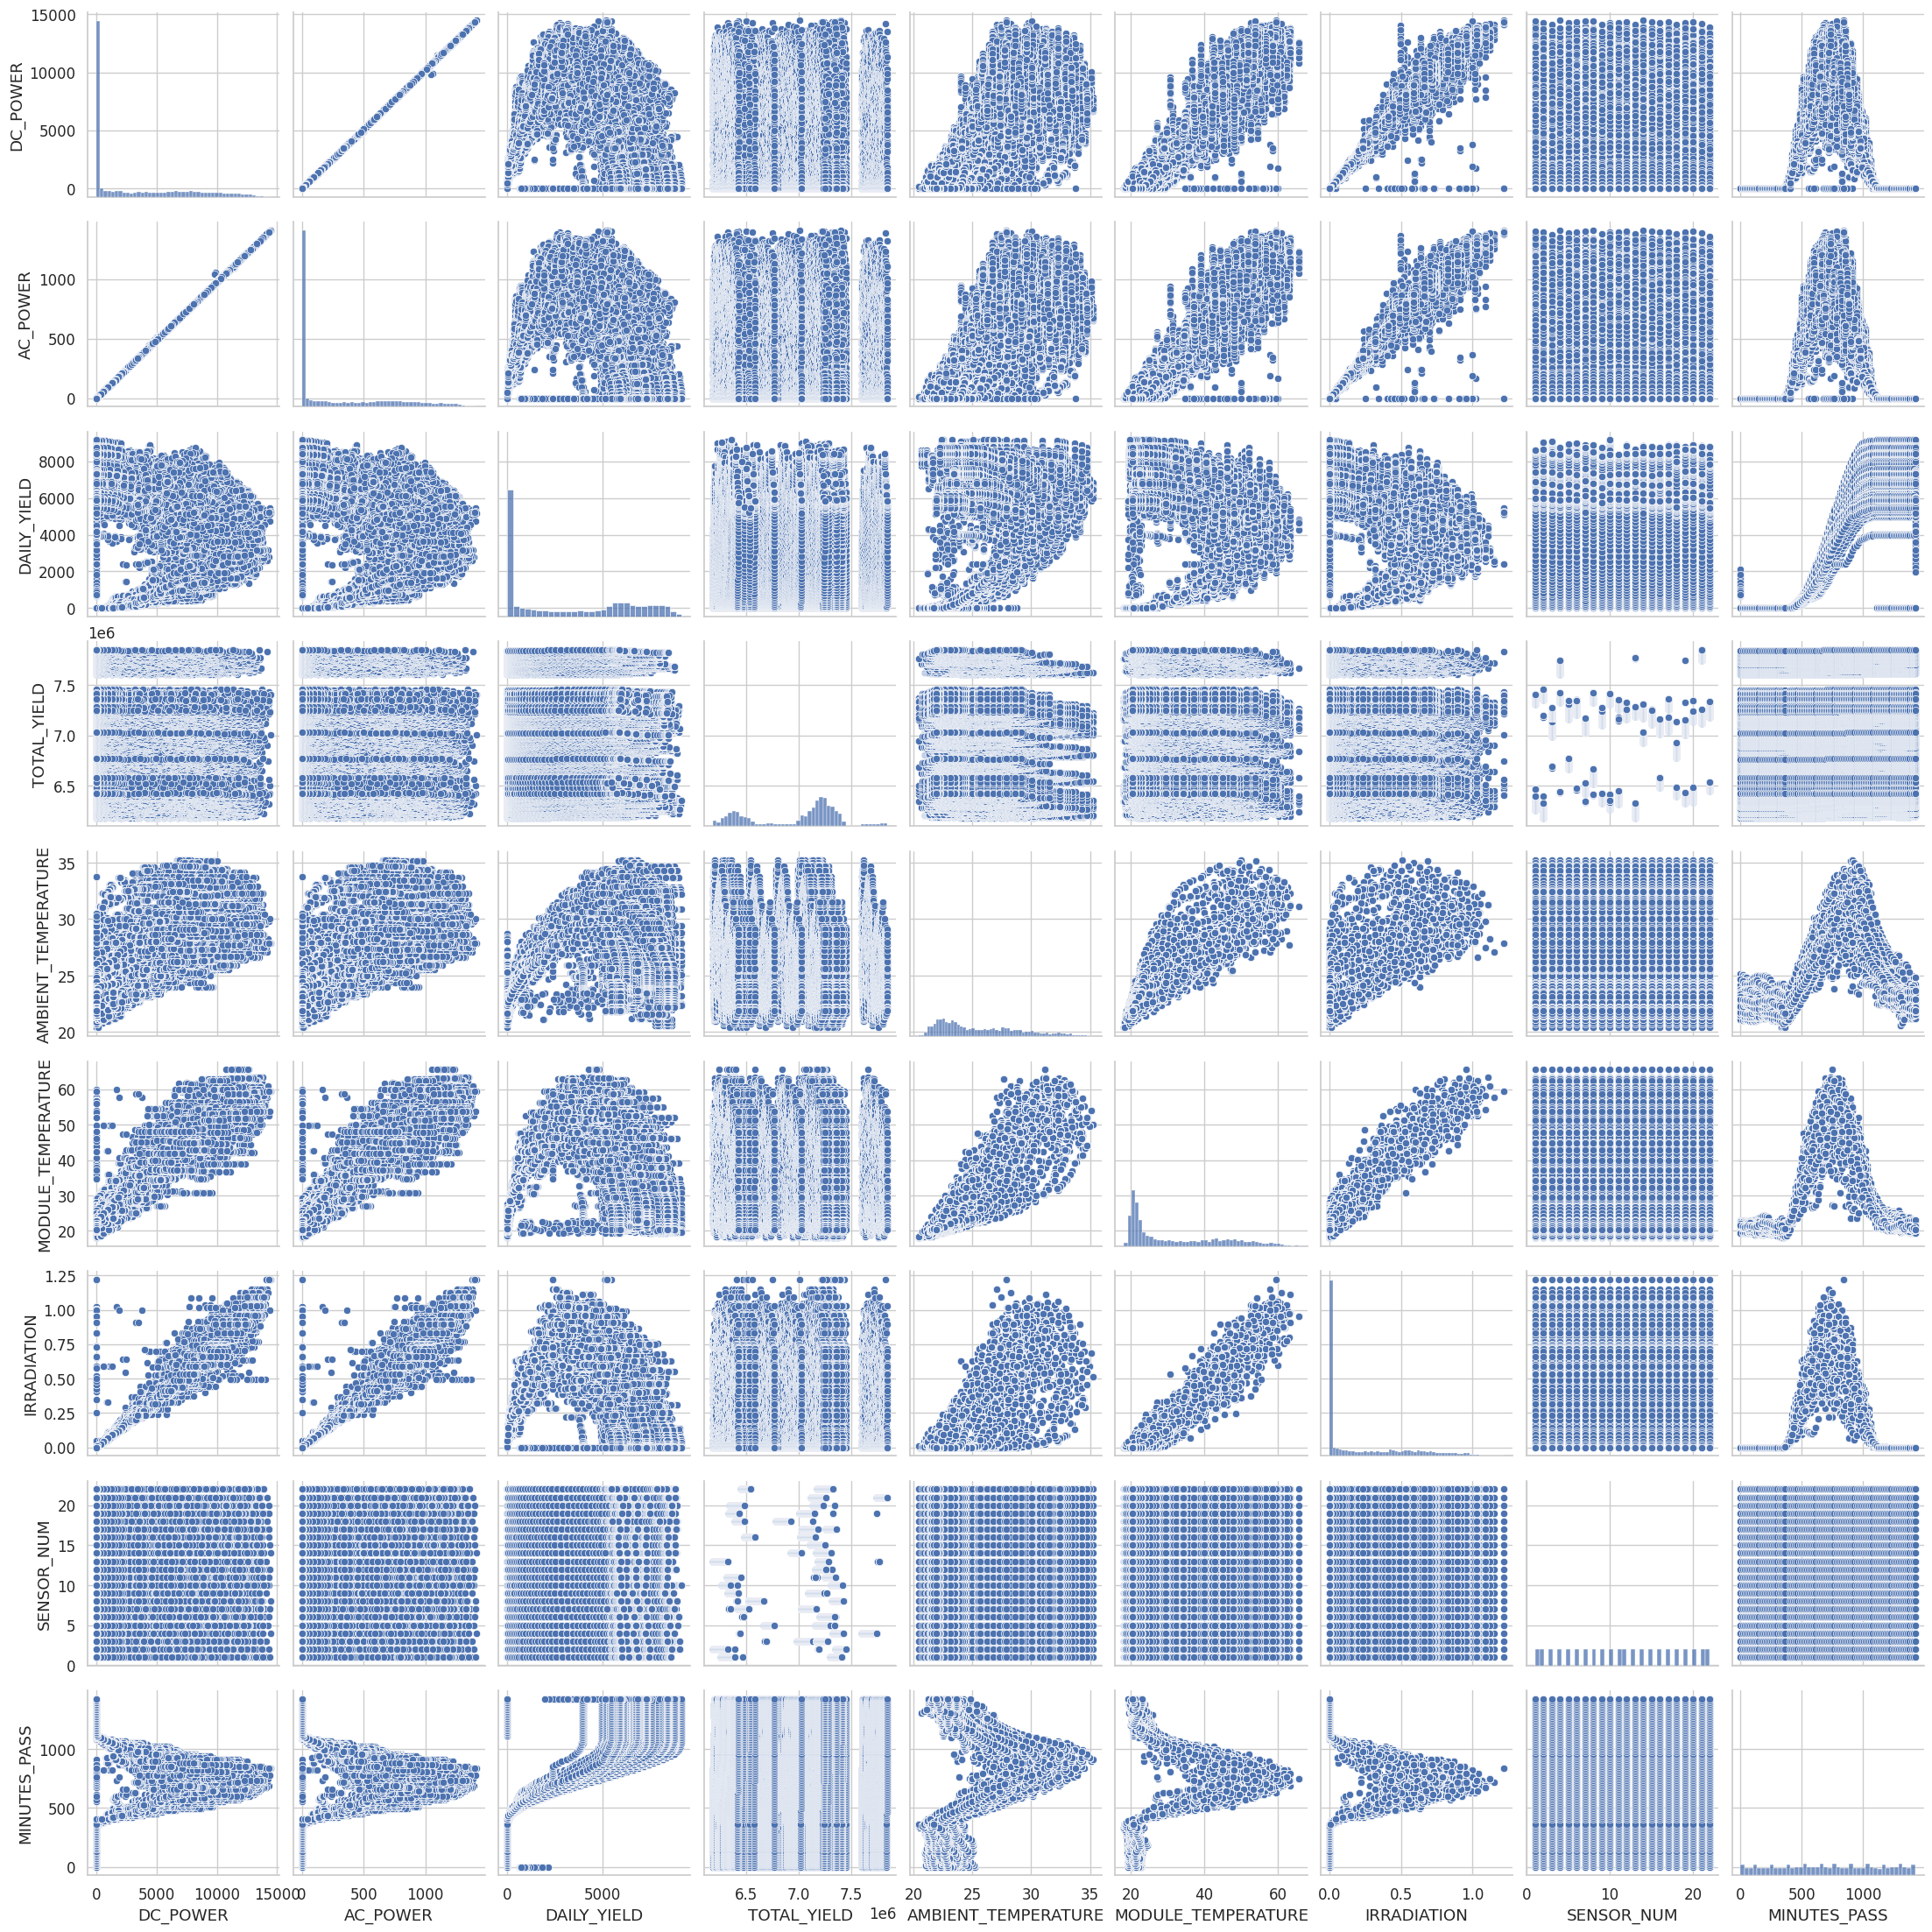

In [47]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
cols_pair = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "SENSOR_NUM", "MINUTES_PASS"]
fig_pair = sns.pairplot(df_plant1[cols_pair])
plt.show()

From the last two figures we already can gain a lot of insight:

    - high correlation between DC Power and AC Power
    - high correlation between Power and Irradiation
    - correlation between DC Power, AC Power and Module Temperature and Ambient Temperature
    - correlation between Daily Yield and Ambient Temperature
<br/>
and that there seem to be outliers in

    - AC+DC Power - Irradiation
    - DC Power - AC Power (very few)
<br/>
We can use these outliers for equipment fault and need for maintenance detection!

    - Outliers in Power-Irradiation indicate failure of the panel lines. If there is enough sunlight but no power is generated, this points to faulty photovoltaic cells.
    - Outliers in DC-AC conversion indicate failure at the inverter. If there is DC power delivered but less AC power generated than expected 
       the inverter may be malfunctioning.

<br/>
If we take a close look at TOTAL_YIELD vs SENSOR_NUM, we see that there are two groups of inverters. One group starts with a higher total yield than the other one. This is most likely because this group was installed earlier than the other group.

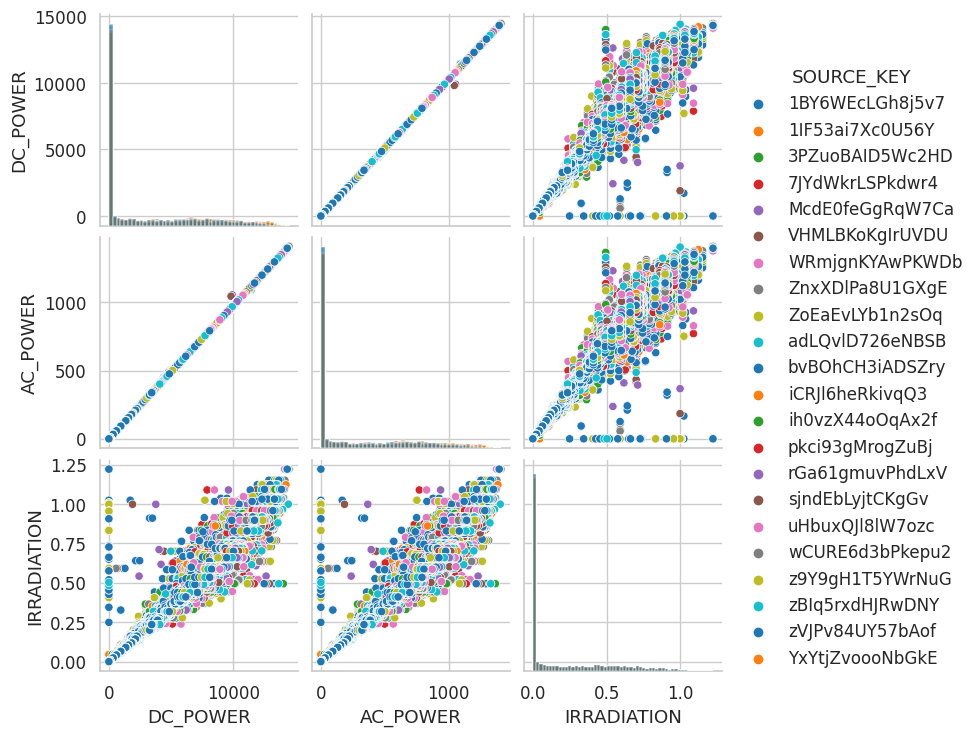

In [48]:
cols_out = ["DC_POWER", "AC_POWER", "IRRADIATION", "SOURCE_KEY"]
sns.pairplot(df_plant1[cols_out], hue="SOURCE_KEY", diag_kind="hist", palette="tab10")
plt.show()

Most of the outliers seem to come from a small group of inverters